__<h2>Most important library:</h2>__

In [1]:
import numpy as np
import pandas as pd
from pathlib import Path
from sklearn import *

from PIL import Image
import cv2

import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid


import tensorflow as tf
from tensorflow.keras import layers
from tensorflow import keras
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, TensorBoard, ModelCheckpoint
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay,classification_report

__<h2>Get Dataset Link,Name,Label and create data frame:</h2>__

In [2]:
image_link=list(Path('../input/rice-image-dataset/Rice_Image_Dataset').glob(r'**/*.jpg'))
image_name=[x.parents[0].stem for x in image_link]
image_label=preprocessing.LabelEncoder().fit_transform(image_name)

In [3]:
df=pd.DataFrame()
df['link']=image_link
df['name']=image_name
df['lable']=image_label

__<h2>Plotting categorical value:</h2>__

<AxesSubplot:>

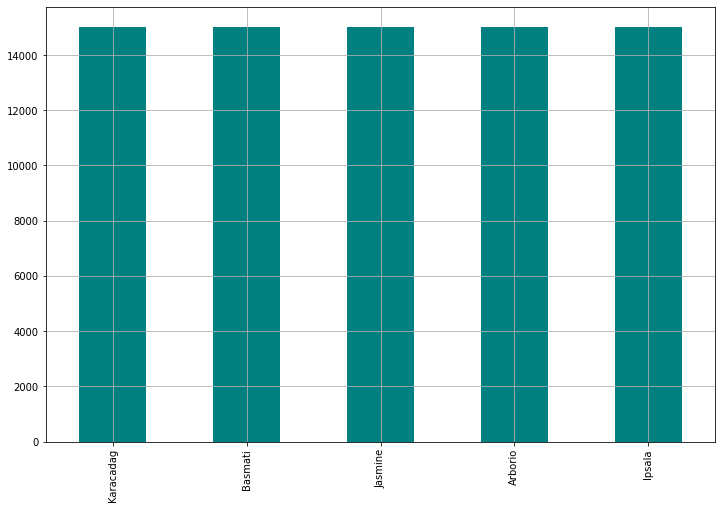

In [4]:
df.name.value_counts().plot(kind='bar',figsize = (12,8), grid = True, color = 'teal')

__<h2>Plotting categorical Image:</h2>__

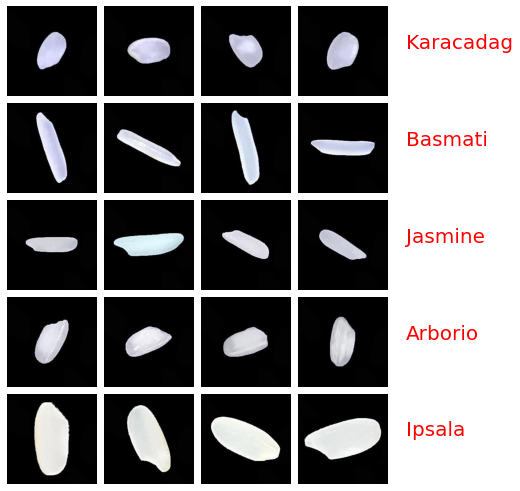

In [5]:
fig=plt.figure(1,figsize=(15,15))
grid=ImageGrid(fig,121, nrows_ncols=(5, 4), axes_pad=0.10)
i=0
for category_id, category in enumerate(df.name.unique()):
    for filepath in df[df['name'] == category]['link'].values[:4]:
        ax = grid[i]
        img=Image.open(filepath)
        ax.imshow(img)
        ax.axis('off')
        if i % 4 == 4 - 1:
            ax.text(300, 100, category, verticalalignment='center',fontsize=20,color = 'red')
        i+=1
        
plt.show()

In [6]:
!pip install split-folders
import splitfolders
splitfolders.ratio('../input/rice-image-dataset/Rice_Image_Dataset',output='./',seed=101, ratio=(.8, .1, .1))

Copying files: 75000 files [06:18, 198.38 files/s]


In [7]:
im_size=(180,180)
batch_size=32
train_data=tf.keras.preprocessing.image_dataset_from_directory('./train',
                                                              validation_split=0.2,
                                                              subset='training',
                                                              seed=1355,
                                                              batch_size=batch_size,
                                                              image_size=im_size
                                                              )
test_data=tf.keras.preprocessing.image_dataset_from_directory('./test',
                                                              validation_split=0.2,
                                                              subset='training',
                                                              seed=1355,
                                                              batch_size=batch_size,
                                                              image_size=im_size
                                                              )
val_data=tf.keras.preprocessing.image_dataset_from_directory('./val',
                                                              validation_split=0.2,
                                                              subset='training',
                                                              seed=1355,
                                                              batch_size=batch_size,
                                                              image_size=im_size
                                                              )

Found 60000 files belonging to 5 classes.
Using 48000 files for training.


2022-10-24 07:40:28.225913: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-24 07:40:28.226852: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-24 07:40:28.393718: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-24 07:40:28.394648: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-24 07:40:28.395482: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from S

Found 7500 files belonging to 5 classes.
Using 6000 files for training.
Found 7500 files belonging to 5 classes.
Using 6000 files for training.


__<h2>Using image data augmentation:</h2>__

In [8]:
image_agmen=tf.keras.Sequential([layers.RandomFlip('horizontal'),layers.RandomRotation(0.1)])

2022-10-24 07:40:34.723991: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


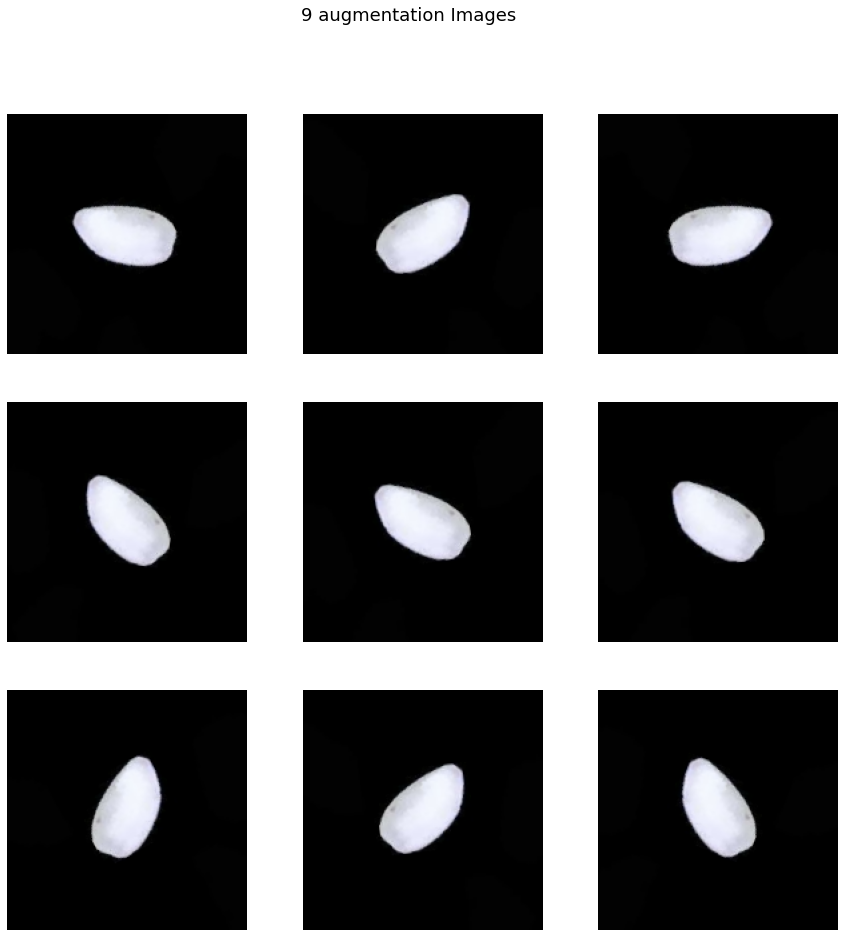

In [9]:
plt.figure(figsize=(15,15))
for img,__ in train_data.take(1):
    for i in range(9):
        imge_ag=image_agmen(img)
        ax=plt.subplot(3,3,i+1)
        plt.imshow(imge_ag[0].numpy().astype('uint8'))
        plt.axis('off')
        plt.suptitle('9 augmentation Images', fontsize=18)

__<h2>Configure the dataset for performance:</h2>__

In [10]:
train_data=train_data.prefetch(buffer_size=batch_size)
val_data=val_data.prefetch(buffer_size=batch_size)

__<h2>Build a model:</h2>__

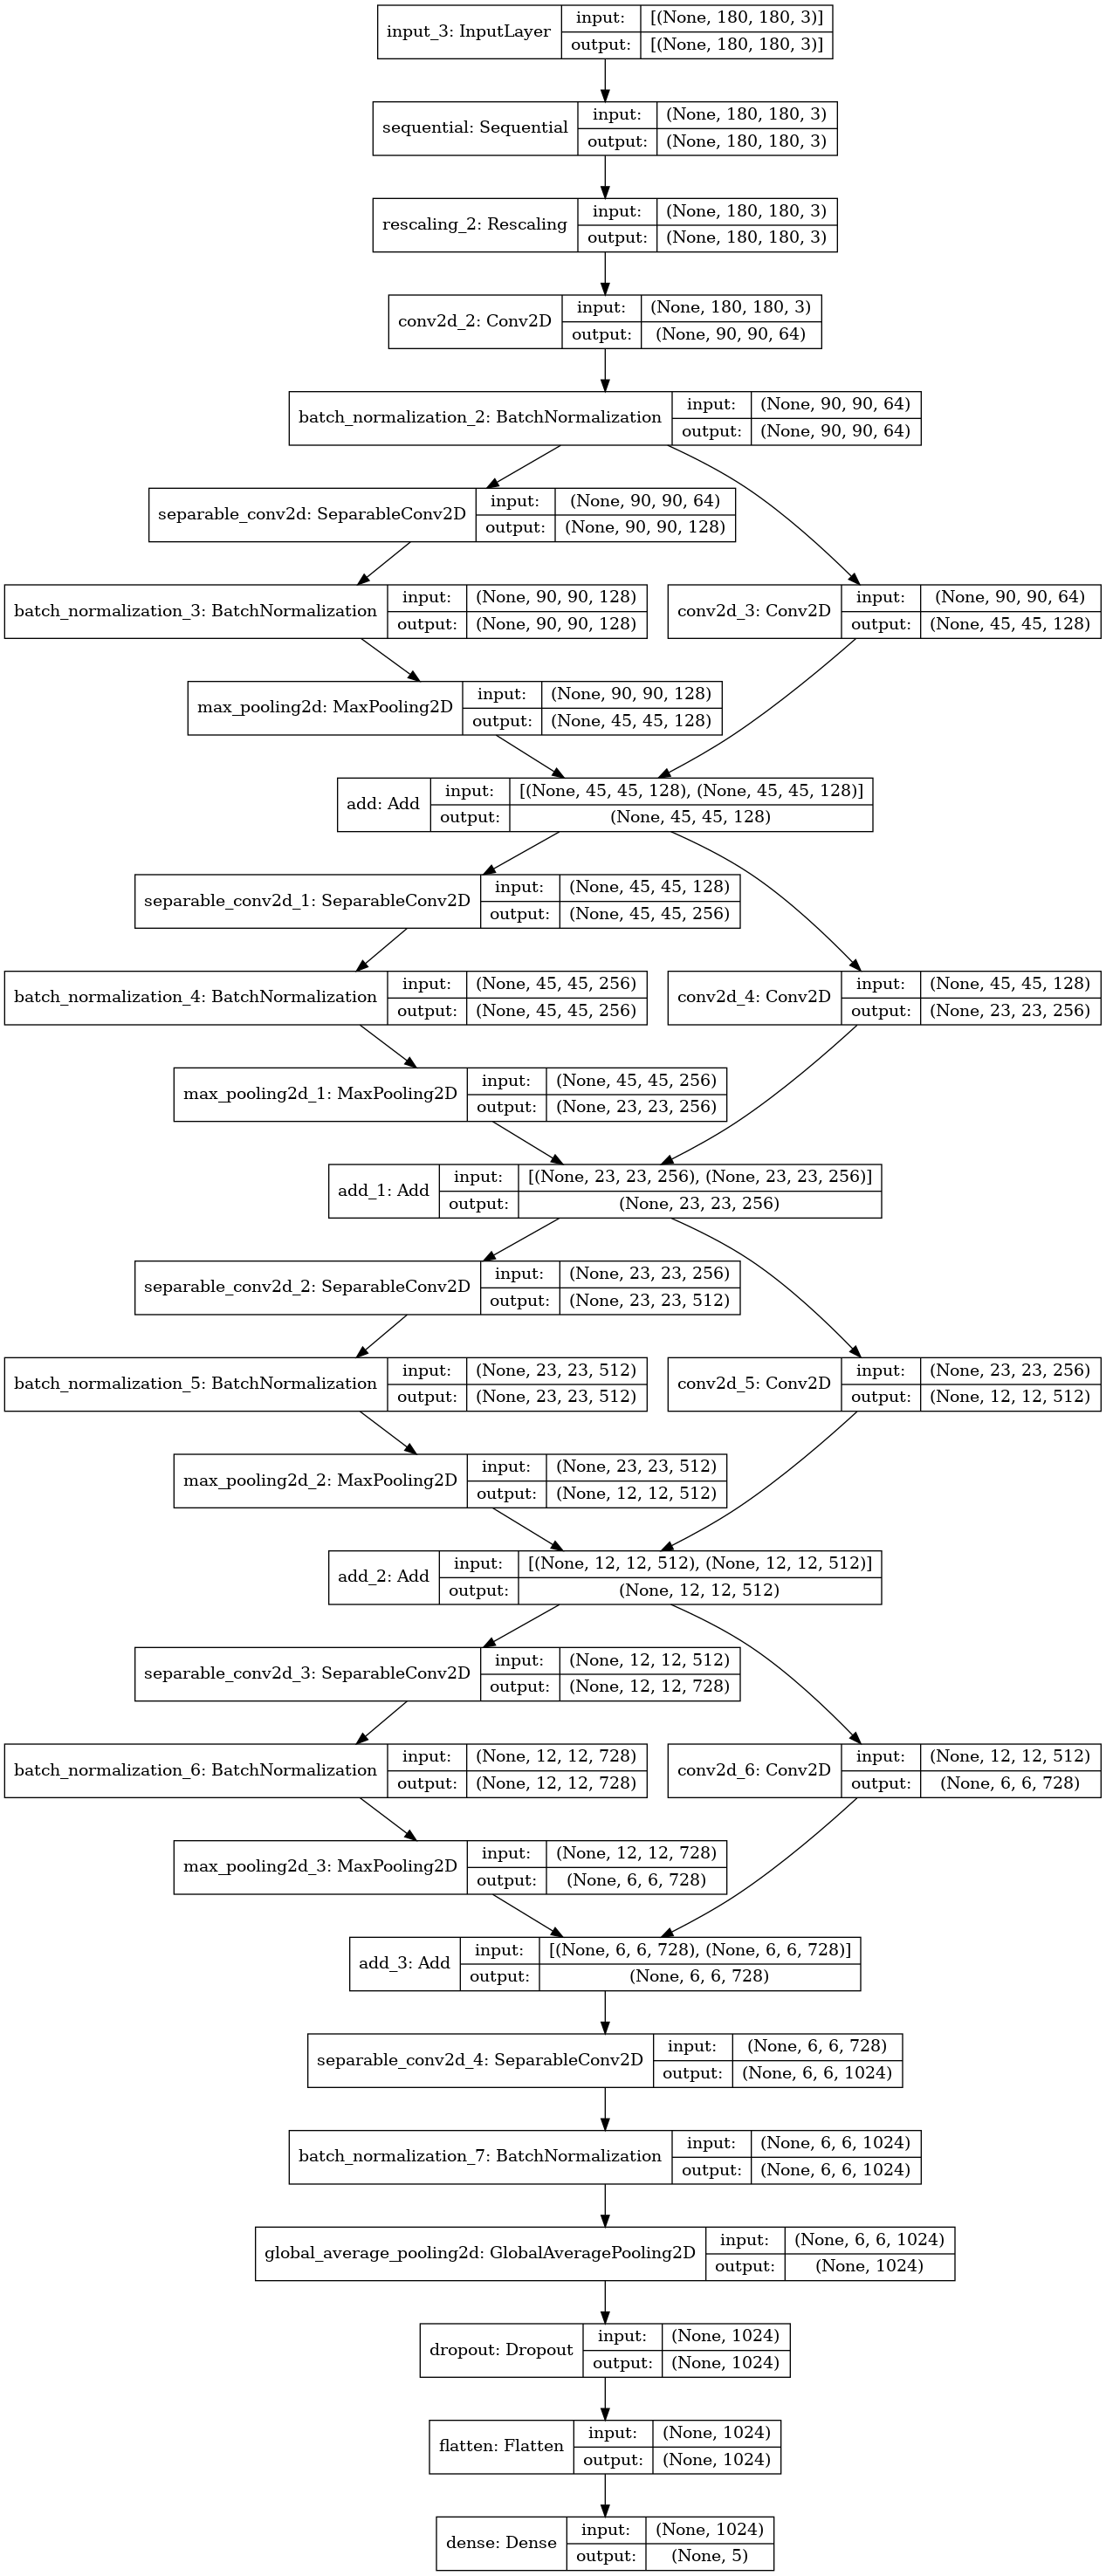

In [11]:
def make_model(input_shape,Act_fun):
    for nur in [16,32,64]:
        inputs=keras.Input(shape=input_shape)
        x=image_agmen(inputs)
        x=layers.Rescaling(1.0/255)(x)
        x=layers.Conv2D(nur,3,strides=2,padding='same', activation='relu')(x)
        x=layers.BatchNormalization()(x)
        
    back_to_priv=x
    
    for nur1 in [128, 256, 512, 728]:
        x=layers.SeparableConv2D(nur1,3,padding='same',activation='relu')(x)
        x=layers.BatchNormalization()(x)
        x=layers.MaxPool2D(3,strides=2, padding="same")(x)
        
        reactive=layers.Conv2D(nur1,1,strides=2, padding="same")(back_to_priv)
        
        x=layers.add([x,reactive])
        back_to_priv=x
        
        
    x=layers.SeparableConv2D(1024, 3, padding="same", activation='relu')(x)
    x=layers.BatchNormalization()(x)
    x=layers.GlobalAveragePooling2D()(x)
    
    if Act_fun==1:
        activation='sigmoid'
        units=Act_fun
    else:
        activation='softmax'
        units=Act_fun
        
    x=layers.Dropout(0.5)(x)
    x=layers.Flatten()(x)
    outputs=layers.Dense(units, activation=activation)(x)
    return keras.Model(inputs, outputs)
    
    
    
activation=5
model = make_model((180,180,3),activation)
keras.utils.plot_model(model, show_shapes=True)

In [12]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 180, 180, 3) 0                                            
__________________________________________________________________________________________________
sequential (Sequential)         (None, 180, 180, 3)  0           input_3[0][0]                    
__________________________________________________________________________________________________
rescaling_2 (Rescaling)         (None, 180, 180, 3)  0           sequential[2][0]                 
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 90, 90, 64)   1792        rescaling_2[0][0]                
______________________________________________________________________________________________

__<h2>Fit a model:</h2>__

In [13]:
model.compile(loss = "sparse_categorical_crossentropy", 
              optimizer = "adam", 
              metrics = "accuracy")

tensorboard = TensorBoard(log_dir="logs")

early_stp=EarlyStopping(monitor='val_accuracy',
                        mode='max', 
                        verbose=1, 
                        patience=20)
checkpoint = ModelCheckpoint('model.h5', 
                             monitor='val_accuracy', 
                             mode='Auto',
                             verbose=1,
                             save_best_only=True )

reduce_LR = ReduceLROnPlateau(monitor="val_accuracy", 
                             factor = 0.3, 
                             patience = 2, 
                             min_delta=0.001, 
                             mode = "auto", 
                            verbose = 1)

History = model.fit(train_data,
                              validation_data=val_data,
                              epochs=10,verbose=1,
                              callbacks=[checkpoint,early_stp,tensorboard,reduce_LR])

2022-10-24 07:40:40.905178: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2022-10-24 07:40:40.905226: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2022-10-24 07:40:40.908208: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1614] Profiler found 2 GPUs
2022-10-24 07:40:41.376193: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2022-10-24 07:40:41.376363: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1748] CUPTI activity buffer flushed
/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 1/10


2022-10-24 07:40:45.050412: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


   1/1500 [..............................] - ETA: 5:07:53 - loss: 1.6524 - accuracy: 0.0938

2022-10-24 07:40:53.948486: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2022-10-24 07:40:53.948574: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.


   2/1500 [..............................] - ETA: 22:14 - loss: 1.3494 - accuracy: 0.3906  

2022-10-24 07:40:54.798632: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2022-10-24 07:40:54.799713: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1748] CUPTI activity buffer flushed
2022-10-24 07:40:54.963597: I tensorflow/core/profiler/internal/gpu/cupti_collector.cc:673]  GpuTracer has collected 382 callback api events and 379 activity events. 
2022-10-24 07:40:54.980541: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.


   3/1500 [..............................] - ETA: 16:02 - loss: 1.0958 - accuracy: 0.5208

2022-10-24 07:40:55.012394: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: logs/train/plugins/profile/2022_10_24_07_40_54

2022-10-24 07:40:55.025733: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzipped tool data for trace.json.gz to logs/train/plugins/profile/2022_10_24_07_40_54/5637ff0ce541.trace.json.gz
2022-10-24 07:40:55.063523: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: logs/train/plugins/profile/2022_10_24_07_40_54

2022-10-24 07:40:55.069307: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzipped tool data for memory_profile.json.gz to logs/train/plugins/profile/2022_10_24_07_40_54/5637ff0ce541.memory_profile.json.gz
2022-10-24 07:40:55.070751: I tensorflow/core/profiler/rpc/client/capture_profile.cc:251] Creating directory: logs/train/plugins/profile/2022_10_24_07_40_54
Dumped tool data for xplane.pb to logs/train/plugins/profile/2022_10_24_07_40_54/5637ff0ce541.xplane.

1500/1500 [==============================] - 201s 126ms/step - loss: 0.0701 - accuracy: 0.9761 - val_loss: 12.5717 - val_accuracy: 0.2123

Epoch 00001: val_accuracy improved from -inf to 0.21233, saving model to model.h5
Epoch 2/10
1500/1500 [==============================] - 191s 127ms/step - loss: 0.0334 - accuracy: 0.9894 - val_loss: 7.4191 - val_accuracy: 0.3635

Epoch 00002: val_accuracy improved from 0.21233 to 0.36350, saving model to model.h5
Epoch 3/10
1500/1500 [==============================] - 191s 127ms/step - loss: 0.0236 - accuracy: 0.9924 - val_loss: 5.4125 - val_accuracy: 0.3910

Epoch 00003: val_accuracy improved from 0.36350 to 0.39100, saving model to model.h5
Epoch 4/10
1500/1500 [==============================] - 192s 128ms/step - loss: 0.0203 - accuracy: 0.9935 - val_loss: 0.3659 - val_accuracy: 0.8903

Epoch 00004: val_accuracy improved from 0.39100 to 0.89033, saving model to model.h5
Epoch 5/10
1500/1500 [==============================] - 191s 127ms/step - los

__<h2>Model performance reports:</h2>__

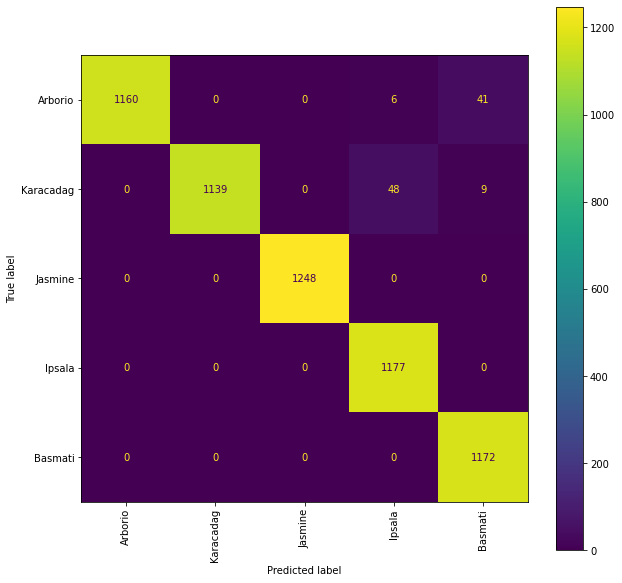

In [14]:
y_lbl=[] # true
t_lbl=[] # predict
imag_data=[] #image array

for img,lbl in test_data:
    y_lbl.append(lbl)
    y_pred = model.predict(img)
    imag_data.append(model.predict(img))
    if activation==1:
        y_pred = ((y_pred > 0.5)+0).ravel()
        t_lbl.append(y_pred)
    elif activation>1:
        y_pred = np.argmax(y_pred, axis=1)
        t_lbl.append(y_pred)


        
        
true_labels = tf.concat([item for item in y_lbl], axis = 0)
predict_labels = tf.concat([item for item in t_lbl], axis = 0)


cm = confusion_matrix(true_labels,predict_labels)
cmp = ConfusionMatrixDisplay(cm,display_labels = ['Arborio', 'Karacadag','Jasmine','Ipsala','Basmati'])
fig, ax = plt.subplots(figsize=(10,10))
cmp.plot(ax=ax, xticks_rotation=90)

In [15]:
print(classification_report(true_labels,predict_labels,target_names=['Arborio', 'Karacadag','Jasmine','Ipsala','Basmati']))

              precision    recall  f1-score   support

     Arborio       1.00      0.96      0.98      1207
   Karacadag       1.00      0.95      0.98      1196
     Jasmine       1.00      1.00      1.00      1248
      Ipsala       0.96      1.00      0.98      1177
     Basmati       0.96      1.00      0.98      1172

    accuracy                           0.98      6000
   macro avg       0.98      0.98      0.98      6000
weighted avg       0.98      0.98      0.98      6000



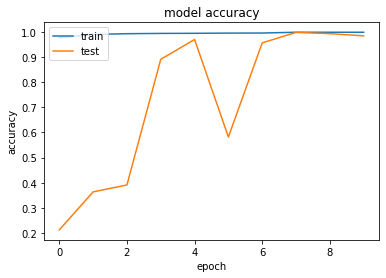

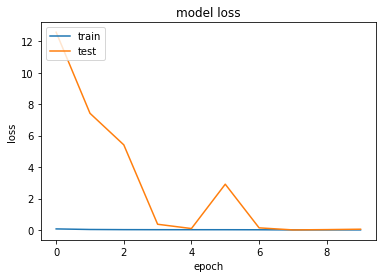

In [16]:
# summarize history for accuracy
plt.plot(History.history['accuracy'])
plt.plot(History.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(History.history['loss'])
plt.plot(History.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()